In [3]:
# general imports
import numpy as np
import matplotlib.pyplot as plt


from astropy.constants import c
import astropy.units as u
from scipy.ndimage import gaussian_filter1d
# import the main class
from funcs.auroralring import AuroralRing

from scipy.optimize import curve_fit
import numpy as np

In [7]:

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 51.7 * np.pi/180


# rotation period in days
P_rot = 3.052 / 24.


# stellar radius in solar radii
R_star = .109

vbins = np.linspace(-80, 80, 240)

delta_alpha = 45/60 / 3.052



def model(vbins, imag, phimax, dphi, alpha_0, broaden=10, N=30, foreshortening=True): 

    # inclination of magnetic axis in radians relative to rotation axis
    i_mag = imag * np.pi/180

    # upper latitude of ring around magnetic axis in radians
    PHI_max = phimax * np.pi/180

    # lower latitude of ring around magnetic axis in radians
    PHI_min = (phimax-dphi) * np.pi/180

    # width of ring around magnetic axis in radians
    width = PHI_max - PHI_min

    # mid latitude of ring around magnetic axis in radians
    mid_lat = (PHI_max + PHI_min) / 2


    # define the auroral ring
    ring = AuroralRing(i_rot=i_rot, i_mag=i_mag, latitude=mid_lat,
                        width=width, Rstar=R_star, P_rot=P_rot, N=60, 
                    v_bins=vbins)

    stop = alpha_0 + delta_alpha
    alphas = np.linspace(alpha_0*np.pi, stop*np.pi, N)

    wav = ring.v_mids / 2.9979246e5 * 6562.8 + 6562.8
    ddv = ring.v_mids[1] - ring.v_mids[0]

    spectra = [ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=foreshortening) for alpha in alphas]

    specs = []
    for spectrum in spectra:
        # fold each spectrum with a gaussian of width 20 km/s
        dv = broaden * u.km / u.s  / ddv
        
        spectrum = gaussian_filter1d(spectrum, dv.value)
        specs.append(spectrum)
        # plt.plot(wav, spectrum)

    # sum and normalize the spectra
    return np.sum(specs, axis=0)

import glob
from astropy.io import fits


files = glob.glob('spectra/*RED_SCI_POINT*.fits')
# sort files by date
files.sort()
files = files[::-1]


rv = 11.6 * u.km/u.s
midwav = 6562.8 * u.AA
offset = (rv / c * midwav).to(u.AA).value

hdu = fits.open(files[3])[0]

x = np.array([hdu.header["CRVAL1"] + hdu.header["CDELT1"] * i for i in range(len(hdu.data))])

mask = (x > 6561) & (x < 6566)

x = x[mask] - offset
y = hdu.data[mask] -85


# # plot the sphere with the auroral ring
# fig, ax = ring.plot_setup_sphere()
# ring.get_flux_numerically(alpha=alpha)
# ring.plot_sphere_with_auroral_ring(ax, alpha=alpha, sphere_alpha=0.01, ring_alpha=1.)
# ring.plot_layout_sphere(ax, view='observer left')


11.110962305246394
30.0 10.0 1.0 0.0 9.0
10.853780103666303
30.0 10.0 5.5 0.0 9.0
10.617345512008136
30.0 10.0 10.0 0.0 9.0
8.543190112534639
30.0 63.333333333333336 1.0 1.5 9.0
8.066184663504691
30.0 63.333333333333336 1.0 1.5 10.571428571428571
7.875418929636509
30.0 63.333333333333336 1.0 1.5 12.142857142857142
7.53422250095232
30.0 90.0 1.0 1.5 10.571428571428571
6.275270989733866
30.0 90.0 1.0 1.5 12.142857142857142
5.565923425991338
30.0 90.0 1.0 1.5 13.714285714285715
5.3832514537283025
30.0 90.0 1.0 1.5 15.285714285714285
4.922753398191617
36.666666666666664 90.0 1.0 1.5 13.714285714285715
4.820780905515321
36.666666666666664 90.0 1.0 1.5 15.285714285714285
4.465154878795769
43.333333333333336 10.0 1.0 0.0 9.0
4.465035236890235
43.333333333333336 10.0 1.0 2.0 9.0
4.307983028655491
43.333333333333336 10.0 5.5 0.0 9.0
4.307964650796102
43.333333333333336 10.0 5.5 2.0 9.0
4.279726809972076
43.333333333333336 10.0 10.0 0.0 9.0
4.279724450336074
43.333333333333336 10.0 10.0 2.0 9.0


/tmp/ipykernel_15565/3926285589.py:24: RuntimeWarning: invalid value encountered in divide
  diffnew = np.sum((m/np.max(m) - y/np.max(y)*0.8)**2)


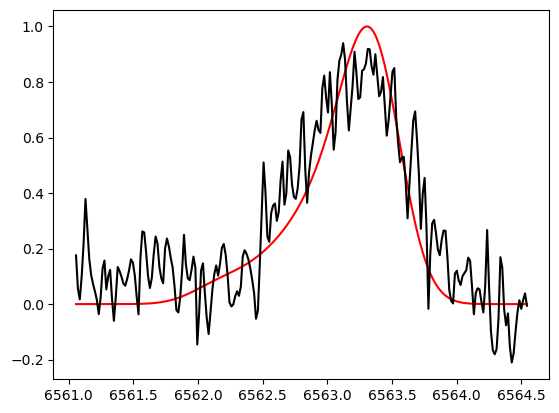

In [8]:
imags = np.linspace(30, 90, 10)
phimaxs = np.linspace(10, 90, 4)
dphis = np.linspace(1, 10, 3)
alpha_0s = np.linspace(0, 2, 5)
broaden = np.linspace(9, 20, 8)

vmids = vbins[:-1] + np.diff(vbins)/2
wav = vmids * u.km/ u.s / c * 6562.8 + 6562.8

#interpolat y to wav
y = np.interp(wav, x, y)
diff = 1e10 
finm = None
#loop over all the parameters
for imag in imags:
    for phimax in phimaxs:
        for dphi in dphis:
            for alpha_0 in alpha_0s:
                for broad in broaden:
                    # print(imag, phimax, dphi, alpha_0, broad)
                    m = model(vbins, imag, phimax, dphi, alpha_0, broaden=broad, N=30, foreshortening=True)
                    # plt.plot(wav, m/np.max(m)*np.max(y)*0.94, alpha=0.1)

                    diffnew = np.sum((m/np.max(m) - y/np.max(y)*0.8)**2)
                    if diffnew < diff:
                        diff = diffnew
                        finm = m
                        print(diff)
                        print(imag, phimax, dphi, alpha_0, broad)
plt.plot(wav, finm/np.max(finm), color='r')
                    

plt.plot(wav,y/np.max(y)*0.94, color='k')

In [ ]:
3: 70.0 63.333333333333336 10.0 1.5 20.0
4: 36.666666666666664 63.333333333333336 5.5 2.0 20.0
7: 56.66666666666667 10.0 5.5 0.0 20.0